# Imports

In [1]:
from typing import Optional, Tuple
import torch
import scipy.sparse as sp
import numpy as np
import networkx as nx
import os, pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
import random
from sklearn.cluster import KMeans
from torch_geometric.utils import from_networkx
from sklearn.metrics import silhouette_score
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from graph import ZoneTransformer
from torch_geometric.explain import (
    Explainer,
    GNNExplainer,
    ModelConfig,
    CaptumExplainer,
    DummyExplainer,
    unfaithfulness,
    fidelity,
)
import captum
from cluster_visualization import visualize_clusters

# Feature Encoding

In [2]:
def print_attrs(path):
    with open(path, "rb") as f:
        g = pickle.load(f)
        for _, attrs in g.nodes(data=True):
            print(attrs)
            break

In [3]:
print_attrs("graphs/graph_match2499719_team1609.pkl")

{'zone_name': 'LEFT_WING_DEF_BOX', 'x_center': 3.0, 'y_center': 90.5, 'in_deg': 0, 'out_deg': 0, 'event_distribution': [0, 0, 0, 0], 'unique_players': 0, 'event_count': 0, 'most_common_event': None, 'role_distribution': [0, 0, 0, 0]}


In [88]:
def build_vocab(source):
    event_vocab, zone_vocab = set(), set()
    if isinstance(source, str):
        file_paths = [os.path.join(source, f) for f in os.listdir(source)
                      if os.path.isfile(os.path.join(source, f))]
    else:
        file_paths = list(source)

    for p in file_paths:
        with open(p, "rb") as f:
            g = pickle.load(f)
        for _, attrs in g.nodes(data=True):
            ev = attrs.get("most_common_event")
            zn = attrs.get("zone_name")
            if ev is not None: event_vocab.add(str(ev))
            if zn is not None: zone_vocab.add(str(zn))

    return sorted(event_vocab), sorted(zone_vocab)

event_vocab, zone_vocab = build_vocab('graphs')
print("Events: ", event_vocab)
print("Zones: ", zone_vocab)

Events:  ['DUEL', 'GOALKEEPER', 'PASS', 'SHOT']
Zones:  ['CENTER_ATT_PENALTY', 'CENTER_ATT_THIRD', 'CENTER_DEF_BOX', 'CENTER_DEF_PENALTY', 'CENTER_DEF_THIRD', 'CENTER_DEF_THIRD_DEEP', 'CENTER_MID_THIRD_ATT', 'CENTER_MID_THIRD_DEF', 'LEFT_HALF_ATT_PENALTY', 'LEFT_HALF_ATT_THIRD', 'LEFT_HALF_DEF_BOX', 'LEFT_HALF_DEF_PENALTY', 'LEFT_HALF_DEF_THIRD', 'LEFT_HALF_DEF_THIRD_DEEP', 'LEFT_HALF_MID_THIRD_ATT', 'LEFT_HALF_MID_THIRD_DEF', 'LEFT_WING_ATT_PENALTY', 'LEFT_WING_ATT_THIRD', 'LEFT_WING_DEF_BOX', 'LEFT_WING_DEF_PENALTY', 'LEFT_WING_DEF_THIRD', 'LEFT_WING_DEF_THIRD_DEEP', 'LEFT_WING_MID_THIRD_ATT', 'LEFT_WING_MID_THIRD_DEF', 'OUTSIDE', 'RIGHT_HALF_ATT_PENALTY', 'RIGHT_HALF_ATT_THIRD', 'RIGHT_HALF_DEF_BOX', 'RIGHT_HALF_DEF_PENALTY', 'RIGHT_HALF_DEF_THIRD', 'RIGHT_HALF_DEF_THIRD_DEEP', 'RIGHT_HALF_MID_THIRD_ATT', 'RIGHT_HALF_MID_THIRD_DEF', 'RIGHT_WING_ATT_PENALTY', 'RIGHT_WING_ATT_THIRD', 'RIGHT_WING_DEF_BOX', 'RIGHT_WING_DEF_PENALTY', 'RIGHT_WING_DEF_THIRD', 'RIGHT_WING_DEF_THIRD_DEEP', '

In [89]:
def encode_node_attributes(attrs, event_vocab, zone_vocab):
    event_onehot = np.zeros(len(event_vocab), dtype=np.float32)
    if attrs["most_common_event"] in event_vocab:
        event_onehot[event_vocab.index(attrs["most_common_event"])] = 1.0

    numeric = np.array(
        [attrs["event_count"], attrs["unique_players"]], dtype=np.float32
    )
    role = np.array(attrs["role_distribution"], dtype=np.float32)

    return np.concatenate([numeric, role, event_onehot])

# Helpers

In [90]:
def normalize_adj(adj):
    adj = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5, where=rowsum > 0)
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return D_inv_sqrt @ adj @ D_inv_sqrt


def scipy_to_torch_sparse(mat):
    mat = mat.tocoo()
    indices = np.vstack((mat.row, mat.col))
    values = mat.data.astype(np.float32)
    edge_index = torch.tensor(indices, dtype=torch.long)
    edge_weight = torch.tensor(values, dtype=torch.float32)
    return edge_index, edge_weight

In [91]:
def get_graph_embedding(path, encoder, event_vocab, zone_vocab, device="cpu"):
    A_norm, A_dense, X = load_graph(path, event_vocab, zone_vocab)

    with open(path, "rb") as file:
        G = pickle.load(file)
    node_order = list(G.nodes)

    # Use dense normalized adjacency directly
    A_hat = torch.tensor(A_dense, dtype=torch.float32).to(device)
    x = torch.tensor(X, dtype=torch.float32).to(device)

    encoder.eval()
    with torch.no_grad():
        Z = encoder(x, A_hat, training=False).cpu().numpy()

    return Z, node_order, G

In [92]:
def cluster_graph_embedding(Z: np.ndarray, n_clusters: Optional[int] = None, random_state: int = 42):
    """Cluster a single graph's embeddings Z and return labels (len = n_nodes).
    If n_clusters is None, we use a simple heuristic based on graph size.
    """
    n = Z.shape[0]
    if n_clusters is None:
        k = max(2, min(12, int(np.ceil(np.sqrt(max(n, 1))/1.5))))
    else:
        k = int(n_clusters)
    km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
    clusters = km.fit_predict(Z)
    return clusters


In [93]:
def visualize_clusters_on_graph(
    G: nx.Graph,
    labels: np.ndarray,
    layout: str = "spring",
    title: Optional[str] = None,
    node_size: int = 140,
):
    nodes = list(G.nodes())
    if len(labels) != len(nodes):
        raise ValueError("labels length must equal number of nodes in G")

    if layout == "kamada":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "embedding":
        raise ValueError(
            "Use 'embedding' layout via visualize_with_embedding(...) below."
        )
    else:
        pos = nx.spring_layout(G, seed=42)

    n_clusters = int(labels.max()) + 1 if len(labels) else 1
    cmap = plt.get_cmap("tab20" if n_clusters > 10 else "tab10", max(n_clusters, 1))
    colors = [cmap(int(c)) for c in labels]

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_edges(G, pos, alpha=0.25, width=0.8)
    nx.draw_networkx_nodes(
        G, pos, node_color=colors, node_size=node_size, edgecolors="k", linewidths=0.3
    )

    # Optional: small zone labels if present
    zone_labels = {}
    for n in nodes:
        zname = G.nodes[n].get("zone_name")
        if isinstance(zname, str) and zname:
            zone_labels[n] = zname
    if zone_labels:
        nx.draw_networkx_labels(G, pos, labels=zone_labels, font_size=7)

    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Data Loading

In [94]:
def load_data(directory, event_vocab, zone_vocab):
    file_name = os.listdir(directory)[0]
    with open(os.path.join(directory, file_name), 'rb') as f:
        graph_data = pickle.load(f)
    adj = nx.adjacency_matrix(graph_data)
    features = [encode_node_attributes(attrs, event_vocab, zone_vocab)
                for _, attrs in graph_data.nodes(data=True)]
    X = np.vstack(features)

    return adj, X

In [95]:
def list_graph_paths(directory):
    paths = [os.path.join(directory, f) for f in os.listdir(directory)
             if os.path.isfile(os.path.join(directory, f))]
    paths.sort()
    return paths

In [96]:
def load_graph(path, event_vocab, zone_vocab):
    with open(path, "rb") as f:
        graph = pickle.load(f)
    A = nx.adjacency_matrix(graph)
    X = np.stack(
        [
            encode_node_attributes(attrs, event_vocab, zone_vocab)
            for _, attrs in graph.nodes(data=True)
        ]
    ).astype(np.float32)

    A_norm = normalize_adj(A)
    A_tf = scipy_to_torch_sparse(A_norm)
    A_dense = np.asarray(A_norm.todense(), dtype=np.float32)

    return A_tf, A_dense, X

# Model

In [99]:
class GCN(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        activation: str = "relu",
        dropout: float = 0.0,
        use_bias: bool = True,
        name: str = None,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.dropout = nn.Dropout(dropout) if dropout and dropout > 0.0 else None

        self.weight = nn.Parameter(torch.empty(in_features, out_features))
        if use_bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter("bias", None)

        self.reset_parameters()
        self.activation = getattr(F, activation) if activation else None

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x: torch.Tensor, A_hat: torch.Tensor, training: bool = False):
        if self.dropout is not None and training:
            x = self.dropout(x)

        support = torch.matmul(x, self.weight)
        Z = torch.matmul(
            A_hat, support
        )  # A_hat should be dense; if sparse, use torch.sparse.mm
        if self.bias is not None:
            Z = Z + self.bias

        if self.activation is not None:
            Z = self.activation(Z)
        return Z

In [100]:
class GAEEncoder(torch.nn.Module):
    def __init__(
        self, input_dim: int, hidden_dim: int, latent_dim: int, dropout: float = 0.0
    ):
        super().__init__()
        self.gcn_hidden = GCN(
            in_features=input_dim,
            out_features=hidden_dim,
            activation="relu",
            dropout=dropout,
        )
        self.gcn_mu = GCN(
            in_features=hidden_dim,
            out_features=latent_dim,
            activation=None,
            dropout=dropout,
        )

    def forward(self, X: torch.Tensor, A_hat: torch.Tensor, training: bool = False):
        H = self.gcn_hidden(X, A_hat, training=training)
        Z = self.gcn_mu(H, A_hat, training=training)
        return Z

In [101]:
class GAEFeatureDecoder(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_units: int,
        hidden_units: int = 64,
        activation: str = "relu",
    ):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, out_units)
        self.activation = getattr(F, activation) if activation else None

    def forward(self, Z: torch.Tensor, training: bool = False):
        h = self.fc1(Z)
        if self.activation:
            h = self.activation(h)
        X_hat = self.fc2(h)
        return X_hat

# Training

In [102]:
sample_path = list_graph_paths("graphs")[0]
_, _, X_sample = load_graph(sample_path, event_vocab, zone_vocab)
input_dim = X_sample.shape[1]
feature_dim = int(X_sample.shape[1])
latent_dim = 8
encoder = GAEEncoder(
    input_dim=input_dim, hidden_dim=32, latent_dim=latent_dim, dropout=0.1
)
decoder = GAEFeatureDecoder(in_dim=latent_dim, out_units=feature_dim, hidden_units=64)

In [103]:
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3
)
mse = nn.MSELoss()

In [104]:
def train_step(X, A_hat, encoder, decoder, optimizer, mse):
    encoder.train()
    decoder.train()

    optimizer.zero_grad()

    # Forward pass
    Z = encoder(X, A_hat, training=True)
    X_hat = decoder(Z, training=True)

    # Optional safety check (usually unnecessary if decoder is defined properly)
    if X_hat.shape[-1] != X.shape[-1]:
        decoder.fc2 = torch.nn.Linear(X_hat.shape[-1], X.shape[-1])
        X_hat = decoder(Z, training=True)

    # Compute loss
    loss = mse(X_hat, X)

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item()

In [34]:
all_paths = list_graph_paths("graphs")
random.Random(42).shuffle(all_paths)
cut = int(0.8 * len(all_paths))
train_paths, test_paths = all_paths[:cut], all_paths[cut:]
print(f"Train graphs: {len(train_paths)}, Test graphs: {len(test_paths)}")

Train graphs: 89, Test graphs: 23


In [105]:
num_epochs = 200

for epoch in tqdm(range(1, num_epochs + 1), desc="Training epochs"):
    train_losses = []

    for path in train_paths:
        A_norm, A_dense, X_np = load_graph(path, event_vocab, zone_vocab)

        # Convert to torch tensors
        X = torch.tensor(X_np, dtype=torch.float32)
        A_hat = torch.tensor(A_dense, dtype=torch.float32)

        loss = train_step(X, A_hat, encoder, decoder, optimizer, mse)
        train_losses.append(loss)

    # if epoch % 5 == 0 or epoch == num_epochs:
    #     mean_loss = np.mean(train_losses)
    #     print(f"Epoch {epoch}, Train Loss: {mean_loss:.4f}")

Training epochs:   0%|          | 0/200 [00:00<?, ?it/s]

In [246]:
@torch.no_grad()
def embedding_fidelity(
    encoder, A_hat, x, explanation, node_id=0, topk=0.2, mode="mask_active"
):
    """
    Embedding fidelity for dense GAE models with sparse one-hot inputs.

    Measures how much the node embedding changes when important features are masked or perturbed.

    Args:
        encoder: trained GAEEncoder (dense adjacency model)
        A_hat: normalized adjacency matrix (torch.Tensor)
        x: node feature matrix (torch.Tensor)
        explanation: explanation object from GNNExplainer or Integrated Gradients
        node_id: node index to explain
        topk: fraction (0-1) of most important features to mask
        mode: "mask_active" (default) or "perturb" — how to modify important features
    """
    encoder.eval()
    x = x.clone().detach().to("cpu")
    A_hat = A_hat.to("cpu")

    # Original embedding
    z_orig = encoder(x, A_hat, training=False)

    # Get node-level importance
    importance = explanation.node_mask
    if importance.dim() > 1:
        importance = importance[node_id]

    importance = importance.to("cpu")
    importance = torch.abs(importance)

    # Only consider features that are nonzero for this node
    active_idx = (x[node_id] != 0).nonzero(as_tuple=True)[0]
    if len(active_idx) == 0:
        return float("nan")  # no active features to mask

    # Restrict importance to active features
    imp_active = importance[active_idx]
    k = max(1, int(len(imp_active) * topk))
    top_idx_rel = torch.topk(imp_active, k).indices
    top_idx = active_idx[top_idx_rel]

    # Mask or perturb those active features
    x_masked = x.clone()
    if mode == "mask_active":
        x_masked[node_id, top_idx] = 0.0
    elif mode == "perturb":
        noise = torch.randn_like(x_masked[node_id, top_idx]) * 0.1
        x_masked[node_id, top_idx] += noise

    # New embedding
    z_masked = encoder(x_masked, A_hat, training=False)

    # Cosine similarity (clamped for numerical safety)
    sim = torch.cosine_similarity(
        z_orig[node_id].unsqueeze(0),
        z_masked[node_id].unsqueeze(0),
    ).clamp(-1.0, 1.0)

    return sim.item()

In [188]:
def embedding_fidelity_old(encoder, decoder, X, A_hat, device="cpu"):
    from sklearn.metrics import mean_squared_error
    from scipy.stats import spearmanr
    """
    Compute embedding fidelity metrics for a trained Graph Autoencoder.

    Measures:
      1. Reconstruction fidelity (MSE between X and X_hat)
      2. Structural fidelity (Spearman correlation between adjacency similarity
         and embedding similarity)
    """
    encoder.eval()
    decoder.eval()
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)

    if not isinstance(A_hat, torch.Tensor):
        A_hat = torch.tensor(A_hat, dtype=torch.float32)

    with torch.no_grad():
        Z = encoder(X, A_hat, training=False)
        X_hat = decoder(Z, training=False)

    recon_mse = mean_squared_error(X.cpu().numpy(), X_hat.cpu().numpy())

    A_np = A_hat.cpu().numpy()
    # cosine similarity of embeddings
    Z_np = Z.cpu().numpy()
    Z_norm = Z_np / np.linalg.norm(Z_np, axis=1, keepdims=True)
    sim_emb = Z_norm @ Z_norm.T
    # flatten both matrices
    A_flat = A_np.flatten()
    sim_flat = sim_emb.flatten()
    # Spearman correlation between adjacency and embedding similarity
    corr, _ = spearmanr(A_flat, sim_flat)

    return {"reconstruction_mse": recon_mse, "structural_fidelity": corr}

In [180]:
def mask_entropy(mask: np.ndarray, eps: float = 1e-12):
    mask = np.clip(mask, eps, 1.0)
    if mask.ndim == 1:
        entropy = -np.sum(mask * np.log(mask))
    else:
        entropy = -np.sum(mask * np.log(mask), axis=1)
    return entropy

In [108]:
def softmax_entropy(mask: np.ndarray, eps: float = 1e-12):
    exp_mask = np.exp(mask - np.max(mask, axis=-1, keepdims=True))
    softmax_mask = exp_mask / (np.sum(exp_mask, axis=-1, keepdims=True) + eps)

    return mask_entropy(softmax_mask, eps)

In [189]:
class EncoderWrapper(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def forward(self, x, edge_index, *args, **kwargs):
        # ignore extra args
        return self.encoder(x, edge_index)

In [229]:
class DenseEncoderWrapper(torch.nn.Module):
    """Wraps a dense GAE encoder for compatibility with PyG's Explainer."""

    def __init__(self, encoder, A_hat):
        super().__init__()
        self.encoder = encoder
        self.A_hat = A_hat

    def forward(self, x, edge_index=None, **kwargs):
        # accepts arbitrary kwargs (e.g., node_index, target)
        return self.encoder(x, self.A_hat, training=False)

In [212]:
def gnn_explainer(
    encoder, path, event_vocab, zone_vocab, device="cpu", node_id=0, epochs=50
):
    """
    Run GNNExplainer on dense GAEEncoder model.

    Args:
        encoder: trained GAEEncoder instance
        path: path to pickled graph file
        event_vocab, zone_vocab: vocabularies used for feature encoding
        device: 'cpu' or 'cuda'
        node_id: node index to explain
        epochs: explainer optimization steps
    """
    A_tf, A_dense, X = load_graph(path, event_vocab, zone_vocab)

    with open(path, "rb") as f:
        team_graph = pickle.load(f)

    x = torch.tensor(X, dtype=torch.float32)

    A_hat = torch.tensor(A_dense, dtype=torch.float32)

    data = from_networkx(team_graph)

    wrapped_model = DenseEncoderWrapper(encoder.to(device), A_hat)

    model_config = ModelConfig(
        mode="regression",
        task_level="node",
        return_type="raw",
    )

    explainer = Explainer(
        model=wrapped_model,
        algorithm=GNNExplainer(epochs=epochs),
        explanation_type="model",
        node_mask_type="attributes",
        edge_mask_type=None,
        model_config=model_config,
    )

    explanation = explainer(
        x=x, edge_index=data.edge_index.to(device), node_index=node_id
    )
    return (A_hat, x), explanation

In [185]:
feat_labels = (
    ["event_count", "unique_players"]
    + [f"role_{i}" for i in ["GK", "DEF", "MID", "FWD"]]
    + [f"event_{e}" for e in event_vocab]
)
print(len(feat_labels))

10


In [139]:
gnn_data = {
    "exp": [],
    "all_masks": [],
    "fidelity": [],
}
for path in tqdm(
    list_graph_paths(f"graphs"),
    desc=f"Computing global feature importance",
    position=tqdm._get_free_pos(),
):
    for node_id in tqdm(
        range(40),
        desc="Zones",
        position=tqdm._get_free_pos(),
        leave=False,
    ):
        d, exp = gnn_explainer(
            encoder, path, event_vocab, zone_vocab, device="cpu", node_id=0
        )
        gnn_data["exp"].append(exp)
        gnn_data["all_masks"].append(exp.node_mask.detach().cpu().numpy().mean(axis=0))
        gnn_data["fidelity"].append(embedding_fidelity(encoder, d[0], d[1], exp))

Computing global feature importance:   0%|          | 0/112 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

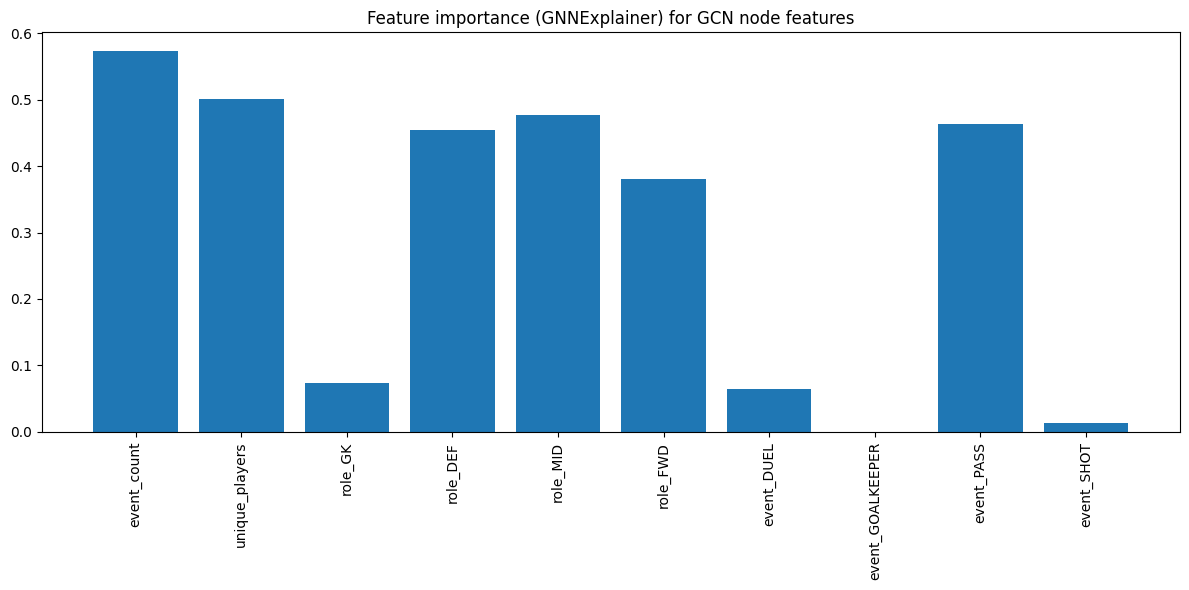

In [142]:
# plot feature importance
gnn_feat_imp = np.mean(gnn_data["all_masks"], axis=0)

plt.figure(figsize=(12, 6))
plt.bar(range(len(gnn_feat_imp)), gnn_feat_imp)
plt.xticks(range(len(gnn_feat_imp)), feat_labels, rotation=90)
plt.title("Feature importance (GNNExplainer) for GCN node features")
plt.tight_layout()
plt.show()

In [146]:
np.mean([i["structural_fidelity"] for i in gnn_data["fidelity"]])

0.4487340723550714

In [147]:
np.mean([i["reconstruction_mse"] for i in gnn_data["fidelity"]])

1.4935257456132345

In [214]:
mask_entropy(gnn_feat_imp)

2.527618

In [241]:
class CaptumWrapper(torch.nn.Module):
    def __init__(self, encoder, A_hat, node_id=0):
        super().__init__()
        self.encoder = encoder
        self.A_hat = A_hat
        self.node_id = node_id

    def forward(self, x, edge_index=None, *args, **kwargs):
        Z = self.encoder(x, self.A_hat, training=False)
        out = Z[self.node_id].mean()  # scalar
        return out.unsqueeze(0)  # shape (1,)

In [247]:
def integrated_gradients(
    encoder, path, event_vocab, zone_vocab, device="cpu", node_id=0
):
    """
    Run Integrated Gradients on dense GAEEncoder model.

    Args:
        encoder: trained GAEEncoder instance
        path: path to pickled graph file
        event_vocab, zone_vocab: vocabularies used for feature encoding
        device: 'cpu' or 'cuda'
        node_id: node index to explain
    """
    A_tf, A_dense, X = load_graph(path, event_vocab, zone_vocab)
    with open(path, "rb") as f:
        team_graph = pickle.load(f)

    x = torch.tensor(X, dtype=torch.float32)
    A_hat = torch.tensor(A_dense, dtype=torch.float32)

    data = from_networkx(team_graph)

    wrapped_model = CaptumWrapper(encoder.to(device), A_hat, node_id=node_id)

    model_config = ModelConfig(
        mode="regression",
        task_level="node",
        return_type="raw",
    )

    algorithm = CaptumExplainer(captum.attr.IntegratedGradients)

    explainer = Explainer(
        model=wrapped_model,
        algorithm=algorithm,
        explanation_type="model",
        node_mask_type="attributes",
        edge_mask_type=None,
        model_config=model_config,
    )

    explanation = explainer(
        x=x.to(device),
        edge_index=data.edge_index.to(device),
        node_index=node_id,
        target=None,
    )

    return (A_hat, x), explanation

In [262]:
ig_data = {
    "exp": [],
    "all_masks": [],
    "fidelity": [],
}
for path in tqdm(
    list_graph_paths(f"graphs"),
    desc=f"Computing global feature importance",
    position=tqdm._get_free_pos(),
):
    for node_id in tqdm(
        range(40),
        desc="Zones",
        position=tqdm._get_free_pos(),
        leave=False,
    ):
        (A_hat, x), exp = integrated_gradients(
            encoder, path, event_vocab, zone_vocab, node_id=node_id
        )
        ig_data["exp"].append(exp)
        ig_data["all_masks"].append(exp.node_mask.detach().cpu().numpy().mean(axis=0))
        ig_data["fidelity"].append(embedding_fidelity_old(encoder, A_hat, x, exp))

Computing global feature importance:   0%|          | 0/112 [00:00<?, ?it/s]

Zones:   0%|          | 0/40 [00:00<?, ?it/s]

AttributeError: 'Tensor' object has no attribute 'eval'

In [260]:
ig_masks = np.mean(ig_data["all_masks"], axis=0)

In [261]:
mask_entropy(ig_masks)

0.010401285

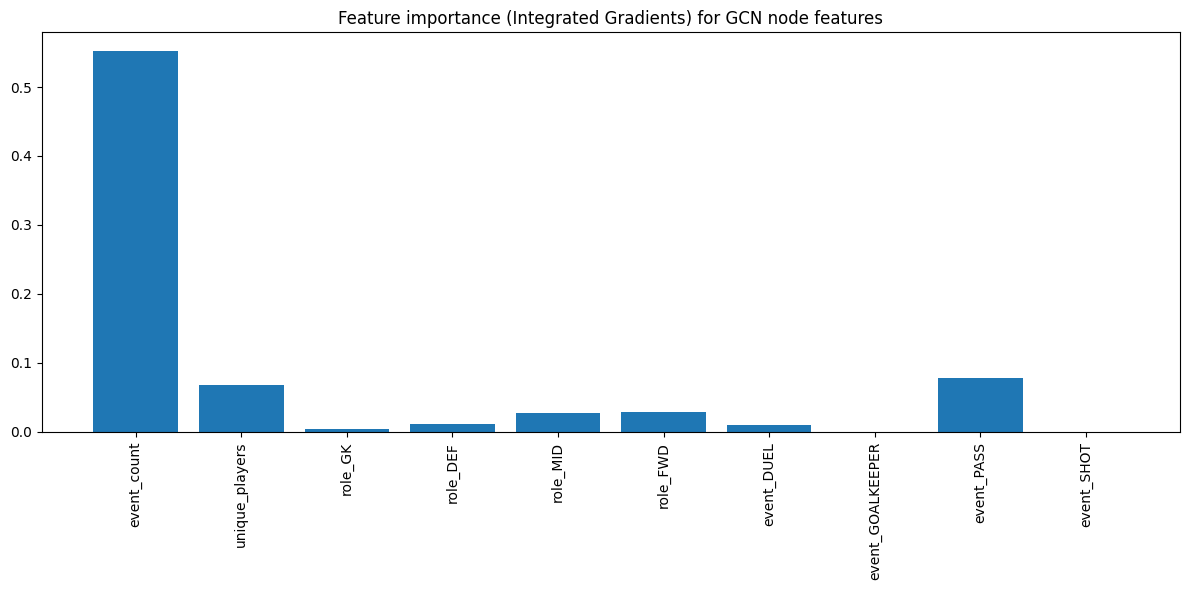

In [267]:
normalized_ig_masks = np.abs(ig_masks / np.max(ig_masks) / 100)

plt.figure(figsize=(12, 6))
plt.bar(range(len(normalized_ig_masks)), normalized_ig_masks)
plt.xticks(range(len(normalized_ig_masks)), feat_labels, rotation=90)
plt.title("Feature importance (Integrated Gradients) for GCN node features")
plt.tight_layout()
plt.show()

# Clustering

In [49]:
path = "graphs/graph_match2499719_team1609.pkl"

Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)

clusters = cluster_graph_embedding(Z, n_clusters=5, random_state=42)

print(clusters)

[1 4 4 4 1 1 4 0 4 1 2 2 2 0 0 0 2 2 2 0 2 3 3 3 2 2 2 2 3 2 4 4 0 0 0 4 4
 4 4 1 2]


c:\Users\Simon.DESKTOP-JJ3ICI6\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Simon.DESKTOP-JJ3ICI6\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\Simon.DESKTOP-JJ3ICI6\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "c:\Users\Simon.DESKTOP-JJ3ICI6\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    wi

# Visualization

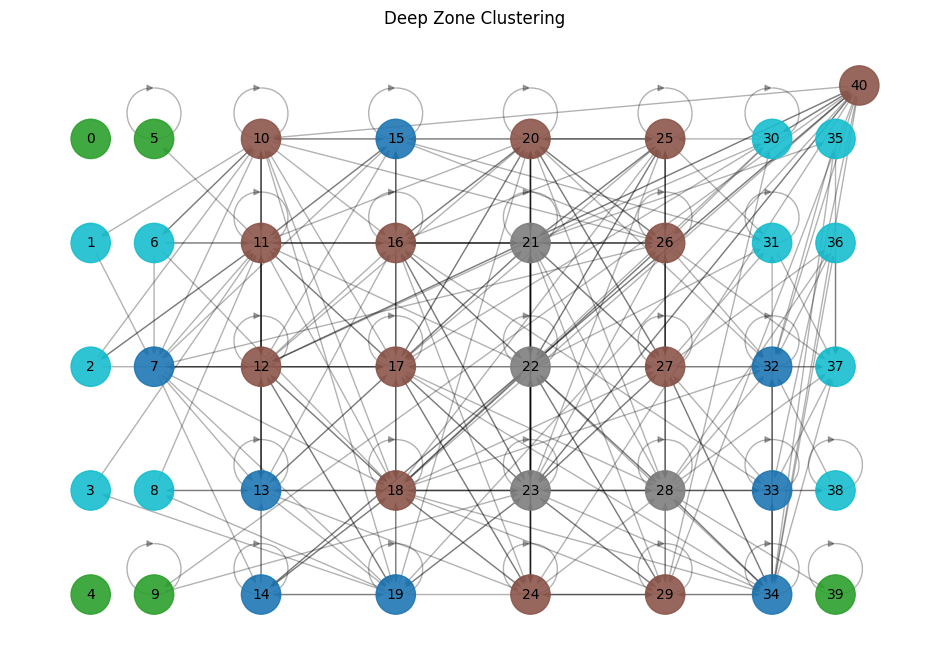

In [50]:
zt = ZoneTransformer()
visualize_clusters(G, Z, clusters, zt)

### NMI

In [51]:
import os
import re
import pickle
import numpy as np
from glob import glob
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import normalize

# === 1. Find all graph files ===
graph_files = sorted(glob('./graphs/*.pkl'))
print(f"Found {len(graph_files)} graphs")

# === 2. Group by team ===
team_graphs = {}
pattern = re.compile(r'team(\d+)')

for f in graph_files:
    match = pattern.search(os.path.basename(f))
    if match:
        team_id = match.group(1)
        team_graphs.setdefault(team_id, []).append(f)

print("\nTeams found:")
for team, files in team_graphs.items():
    print(f"  Team {team}: {len(files)} matches")

# === 3. Compute mean NMI per team ===
team_nmi_summary = {}

for team, files in team_graphs.items():
    print(f"\n=== Processing Team {team} ===")

    cluster_labels = []

    for file in sorted(files):
        # with open(file, 'rb') as f:
        #     G = pickle.load(f)

        Z, node_order, G = get_graph_embedding(file, encoder, event_vocab, zone_vocab)

        labels = cluster_graph_embedding(Z, 5, random.seed(42))

        cluster_labels.append(labels)

    # Compute pairwise NMI between matches of this team
    nmi_scores = []
    for (labels_i, labels_j) in combinations(cluster_labels, 2):
        if len(labels_i) == len(labels_j):
            nmi_scores.append(normalized_mutual_info_score(labels_i, labels_j))

    # Store mean/std NMI
    if nmi_scores:
        mean_nmi = np.mean(nmi_scores)
        std_nmi = np.std(nmi_scores)
        team_nmi_summary[team] = (mean_nmi, std_nmi)
        print(f"Mean NMI: {mean_nmi:.4f}, Std: {std_nmi:.4f}")
    else:
        print("Not enough comparable matches (different #nodes or only one match).")

# === 4. Print final summary ===
print("\n=== Overall NMI Summary ===")
for team, (mean_nmi, std_nmi) in team_nmi_summary.items():
    print(f"Team {team}: Mean NMI = {mean_nmi:.4f}, Std = {std_nmi:.4f}")


Found 112 graphs

Teams found:
  Team 1609: 38 matches
  Team 1625: 37 matches
  Team 1612: 37 matches

=== Processing Team 1609 ===
Mean NMI: 0.4534, Std: 0.0650

=== Processing Team 1625 ===
Mean NMI: 0.4643, Std: 0.0766

=== Processing Team 1612 ===
Mean NMI: 0.4813, Std: 0.0685

=== Overall NMI Summary ===
Team 1609: Mean NMI = 0.4534, Std = 0.0650
Team 1625: Mean NMI = 0.4643, Std = 0.0766
Team 1612: Mean NMI = 0.4813, Std = 0.0685
